In [1]:
import pandas as pd
import os
import numpy as np
import pandas_profiling

# This line is needed to display plots inline in Jupyter Notebook
%matplotlib inline

# Required for basic python plotting functionality
import matplotlib.pyplot as plt

# Required for formatting dates later in the case
import datetime
import matplotlib.dates as mdates

# Required to display image inline
from IPython.display import Image

# Advanced plotting functionality with seaborn
import seaborn as sns
sns.set(style="whitegrid") # can set style depending on how you'd like it to look

import folium  #needed for interactive map
from folium.plugins import HeatMap

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [2]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')

### Maps

#### Heatmap

In [3]:
max_amount = float(yellow_trips['passenger_count'].max())

folium_hmap = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

hm_wide = HeatMap( list(zip(yellow_trips['pickup_latitude'], yellow_trips['pickup_longitude'], 
                            yellow_trips['passenger_count'])),
                   min_opacity=0.2,
                   max_val=max_amount,
                   radius=8, blur=6, 
                   max_zoom=15, 
                 )

folium_hmap.add_child(hm_wide);
path = 'Results'
folium_hmap.save(path + "/Maps/heatmap_yellow_trips.html")

In [4]:
folium_map = folium.Map(location=[40.738, -73.98],
                        zoom_start=13,
                        tiles="OpenStreetMap")

yellow_trips = yellow_trips.reset_index()

for i in range(0,1000):
    marker = folium.CircleMarker(location=[yellow_trips["pickup_latitude"][i],
                                           yellow_trips["pickup_longitude"][i]],
                                 radius=5,color="b",fill=True)
    marker.add_to(folium_map)

path = 'Results'
folium_map.save(path + "/Maps/markmap_yellow_trips.html")

### Trips graphs

In [5]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_nta.parquet', engine = 'pyarrow')

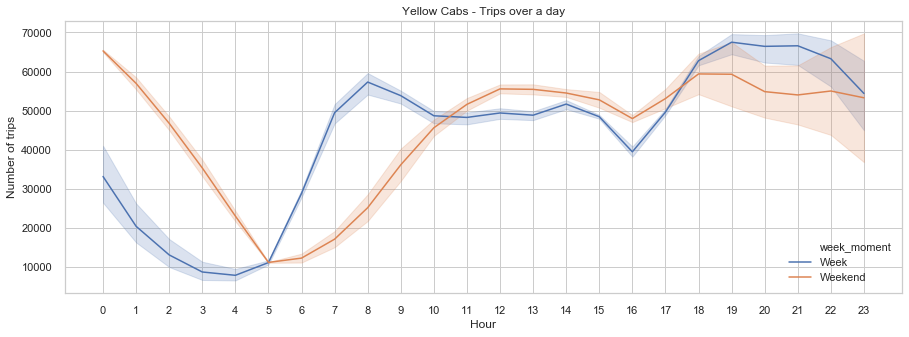

In [6]:
yellow_trips['pickup_hour'] = yellow_trips['pickup_datetime'].dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['week_moment'] = np.where(yellow_trips['pickup_weekday'] <= 4, 'Week', 'Weekend')
yellow_trips['pickup_weekday'] = np.where(yellow_trips['pickup_weekday'] == 0, 'Monday',
                                           np.where(yellow_trips['pickup_weekday'] == 1, 'Tuesday',
                                                   np.where(yellow_trips['pickup_weekday'] == 2, 'Wednesday',
                                                           np.where(yellow_trips['pickup_weekday'] == 3, 'Thursday',
                                                                   np.where(yellow_trips['pickup_weekday'] == 4, 'Friday',
                                                                           np.where(yellow_trips['pickup_weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = yellow_trips.groupby(['pickup_hour', 'pickup_weekday', 'week_moment'])['pickup_longitude'].count().reset_index()
#Accidents_Hour['HOUR'] = Accidents_Hour['HOUR'].astype('str')

fig, ax = plt.subplots(figsize=(15,5))
m = sns.lineplot(x="pickup_hour", y="pickup_longitude", hue = 'week_moment', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of trips')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow Cabs - Trips over a day');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_hour_week.png')

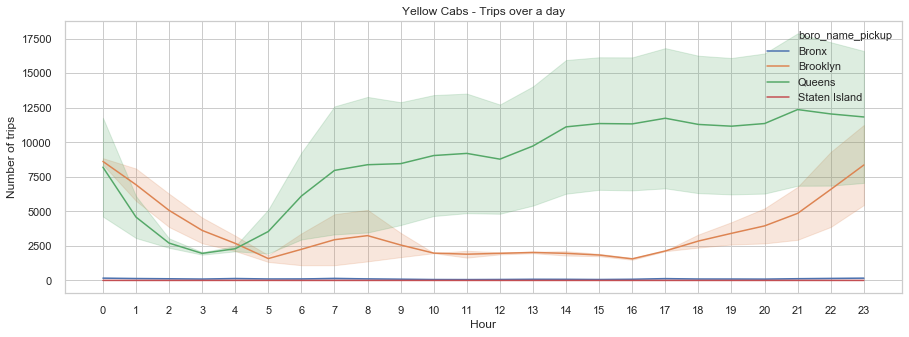

In [7]:
yellow_trips['pickup_hour'] = yellow_trips['pickup_datetime'].dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['week_moment'] = np.where(yellow_trips['pickup_weekday'] <= 4, 'Week', 'Weekend')
yellow_trips['pickup_weekday'] = np.where(yellow_trips['pickup_weekday'] == 0, 'Monday',
                                           np.where(yellow_trips['pickup_weekday'] == 1, 'Tuesday',
                                                   np.where(yellow_trips['pickup_weekday'] == 2, 'Wednesday',
                                                           np.where(yellow_trips['pickup_weekday'] == 3, 'Thursday',
                                                                   np.where(yellow_trips['pickup_weekday'] == 4, 'Friday',
                                                                           np.where(yellow_trips['pickup_weekday'] == 5, 'Saturday', 'Sunday'))))))

Trips_hour = yellow_trips.groupby(['pickup_hour', 'boro_name_pickup', 'week_moment'])['pickup_longitude'].count().reset_index()
#Accidents_Hour['HOUR'] = Accidents_Hour['HOUR'].astype('str')
Trips_hour = Trips_hour.loc[Trips_hour['boro_name_pickup'] != 'Manhattan']

fig, ax = plt.subplots(figsize=(15,5))
m = sns.lineplot(x="pickup_hour", y="pickup_longitude", hue = 'boro_name_pickup', data=Trips_hour, ax=ax)
ax.set(xlabel='Hour', ylabel='Number of trips')
ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow Cabs - Trips over a day');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_hour_borough.png')

#### Boxplots

In [8]:
path = 'Dataset/Parquets'
yellow_trips = pd.read_parquet(path + '/yellow_trips_filtered.parquet', engine = 'pyarrow')

In [9]:
yellow_trips['pickup_month_dt'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('M')
yellow_trips['pickup_date'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.to_period('d')
yellow_trips['pickup_hour'] = pd.to_datetime(yellow_trips['pickup_datetime']).dt.hour
yellow_trips['pickup_weekday'] = yellow_trips['pickup_datetime'].dt.dayofweek
yellow_trips['weekend'] = np.where(yellow_trips['pickup_weekday'] <= 4, False, True)
yellow_trips['rush'] = np.where(((yellow_trips['pickup_hour'] >= 6) & (yellow_trips['pickup_hour'] <= 9)) |
                               ((yellow_trips['pickup_hour'] >= 15) & (yellow_trips['pickup_hour'] <= 20)), True, False)

In [10]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date', 'weekend', 'rush'])['passenger_count'].count().reset_index(name = 'trips')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,weekend,rush,trips
0,2014-04,2014-04-01,False,False,10442
1,2014-04,2014-04-01,False,True,11764
2,2014-04,2014-04-02,False,False,11331
3,2014-04,2014-04-02,False,True,11534
4,2014-04,2014-04-03,False,False,11863


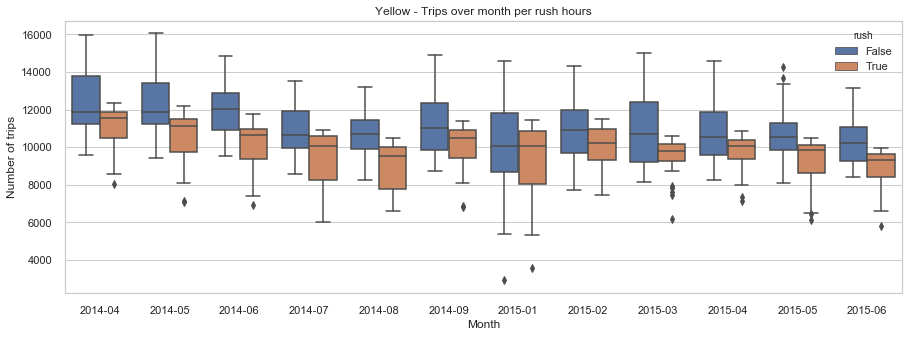

In [11]:
fig, ax = plt.subplots(figsize=(15,5))
m = sns.boxplot(x="pickup_month_dt", y="trips", hue = 'rush', data=yellow_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of trips')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow - Trips over month per rush hours');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_month_rush.png')

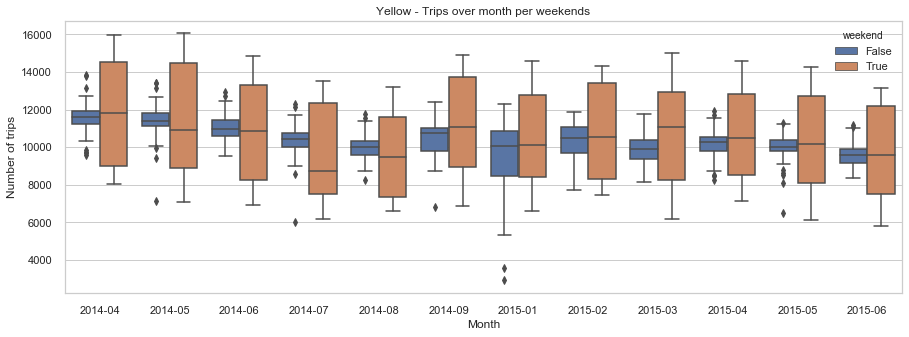

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
m = sns.boxplot(x="pickup_month_dt", y="trips", hue = 'weekend', data=yellow_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Number of trips')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
#plt.ylim(0, 18000)
plt.title('Yellow - Trips over month per weekends');
path = 'Results'
plt.savefig(path + '/Images/yellow_trips_month_weekend.png')

In [13]:
yellow_trips_day = yellow_trips.groupby(['pickup_month_dt', 'pickup_date'])['trip_distance'].mean().reset_index(name = 'avg_trip_distance')
yellow_trips_day.head()

,pickup_month_dt,pickup_date,avg_trip_distance
0,2014-04,2014-04-01,2.918699
1,2014-04,2014-04-02,2.918068
2,2014-04,2014-04-03,3.009486
3,2014-04,2014-04-04,2.903823
4,2014-04,2014-04-05,2.878695


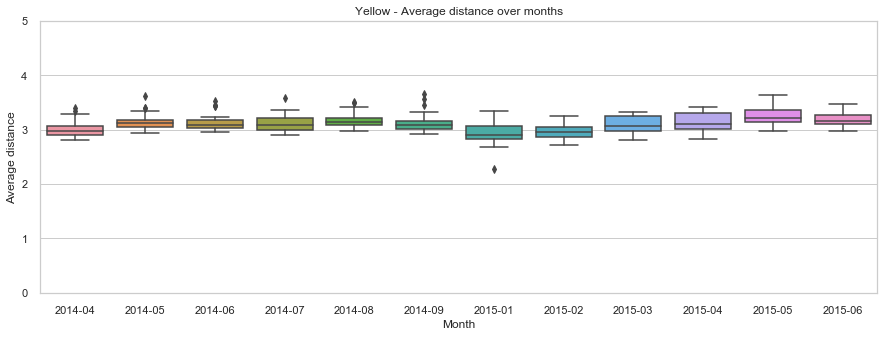

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
m = sns.boxplot(x="pickup_month_dt", y="avg_trip_distance", data=yellow_trips_day, ax=ax)
ax.set(xlabel='Month', ylabel='Average distance')
#ax.set_xticks(np.arange(0, 24,1))
#plt.xticks(rotation=90);
plt.xticks
plt.ylim(0, 5)
plt.title('Yellow - Average distance over months');
path = 'Results'
plt.savefig(path + '/Images/yellow_avgdistance_month.png')